<a href="https://colab.research.google.com/github/duvancatan/Time_Series_UdeA/blob/main/6_Air_Passengers_SARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

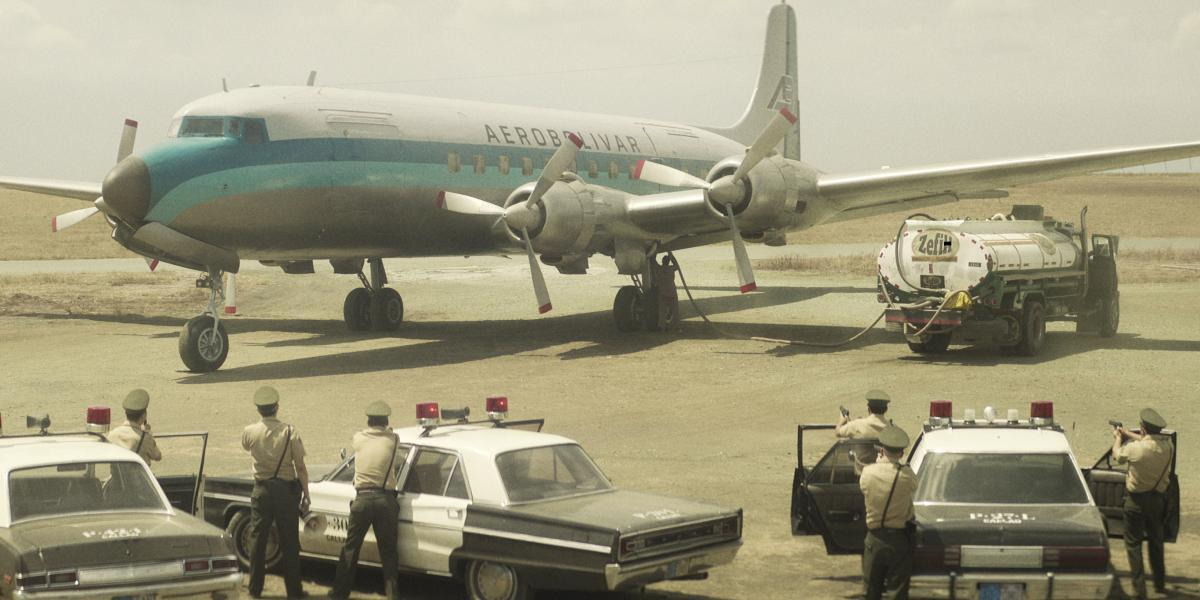

# ***Número de Pasajeros Aéreos***

El conjunto de datos contiene una serie de tiempo del número total mensual de pasajeros de aerolíneas internacionales desde 1949 hasta 1960. El conjunto de datos contiene 144 observaciones en miles.

# Librerías y Carga de los Datos

Se recomienda ejecutar la rutina en R-Studio, ya que Colab presenta algunos  problemas de compatibilidad entre algunas librerías.

In [ ]:
# Primero se debe ejecutar este comando con entorno de Python para conectar con Drive #
# posteriormente cambiar el entorno para R. #
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Instalar Librerías #
# Se sugiere cargar previo a la presentación, es demorado en Colab #
install.packages("stats")
install.packages("astsa")
install.packages("forecast")
install.packages("tseries")
install.packages("nortest")
install.packages("fBasics")
install.packages("car")
install.packages("MLmetrics")
install.packages("matrixcalc")
install.packages("aTSA")
install.packages("MASS")
install.packages("TSA")
install.packages("pastecs")

In [ ]:
# Cargar Librerías #
library(stats)
library(astsa)
library(forecast)
library(tseries)
library(nortest)
library(fBasics)
library(car)
library(MLmetrics)
library(matrixcalc)
library(aTSA)
library(MASS)
library(TSA)
library(pastecs)

In [ ]:
# El paquete "googledrive" es una herramienta específica para interactuar con Google Drive desde R.
# Permite a los usuarios realizar una variedad de acciones relacionadas con Google Drive, como autenticarse
# en sus cuentas de Google, acceder a archivos y carpetas, cargar archivos en Google Drive y descargar archivos de Google Drive.
install.packages("googledrive")
library(googledrive)

In [ ]:
# Leer el archivo .txt desde mi Drive como un objeto ts() #
pasaj = ts(scan("/content/drive/MyDrive/Colab Notebooks/6_pasaj.txt"), start=1949, frequency=12)

# Análisis Descriptivo

In [ ]:
# Graficar la serie #
ts.plot(pasaj, ylab="Pasajeros", main="Serie de Número de Pasajeros de Aerolíneas", lwd=2); grid(col = "black")

In [ ]:
# Tabla Buys-Ballot library(pastecs)#
tb_bb = buysbal(pasaj, y=NULL, frequency=12, dateformat="m/Y")
tb_bb

In [ ]:
# Graficar la serie con periodos de cada 12 meses #
ts.plot(pasaj, ylab="Pasajeros", main="Serie de Número de Pasajeros de Aerolíneas", lwd=2); grid()
abline(v=c(seq(1949,1960)), col="red")

### Transformación de Box-Cox

In [ ]:
# Alternativa 1 (car) #
pasaj_BC = powerTransform(pasaj)
pasaj_BC

In [ ]:
# Alternativa 2 (MASS) #
boxcox(pasaj ~ 1, lambda = seq(-2, 2, 1/10), plotit = TRUE, xlab = expression(lambda), ylab = "Transformación Box-Cox")

In [ ]:
# Notemos que el valor de lambda es próximo a cero, por lo que realizamos una transformación logarítmica #
pasajt = log(pasaj)

In [ ]:
# Graficar serie original y en logarítmica #
par(mfrow=c(2,1))
plot(pasaj, main="Serie Original")
plot(log(pasaj), main="Logaritmo de la serie")

In [ ]:
# Graficos estacionales #
par(mfrow=c(3,1))
ts.plot(pasajt,  main="Log Número de pasajeros")
monthplot(pasajt, main="Log Número de pasajeros para cada mes con el promedio")
seasonplot(pasajt, main="Log Perfil estacional")

## Funciones de Autocorrelación y Autocorrelación Parcial

In [ ]:
# ACF y PACF muestrales en un solo gráfico #
par(mfrow=c(2,1))
acf(pasajt, lag.max=48, main="ACF de la serie transformada")     # ACF hasta el rezago 48
pacf(pasajt, lag.max=48, main="PACF de la serie transformada")    # PACF hasta el rezago 48

# Alternativamente para obtener la ACF y PACF en un solo comando (astsa) #
#acf2(pasajt)

In [ ]:
# ACF y PACF muestrales de la primera diferencia ordinaria, (1-B) #
par(mfrow=c(2,1))
acf(diff(pasajt), lag.max=48, main="ACF de la diferencia transformada de la serie")     # ACF hasta el rezago 48
pacf(diff(pasajt), lag.max=48, main="PACF de la diferencia transformada de la serie")    # PACF hasta el rezago 48

# Alternativamente para obtener la ACF y PACF en un solo comando (astsa) #
# acf2(diff(pasajt))

In [ ]:
# ACF y PACF muestrales de la primera diferencia estacional (1-B^12) #
par(mfrow=c(2,1))
acf(diff(pasajt, lag=12), lag.max=48, main = "ACF de la diferencia estacional 12")     # ACF hasta el rezago 48
pacf(diff(pasajt, lag=12), lag.max=48, main = "PACF de la diferencia estacional 12")    # PACF hasta el rezago 48

# Alternativamente para obtener la ACF y PACF en un solo comando (astsa) #
# acf2(diff(pasajt, lag=12))

In [ ]:
# ACF y PACF muestrales de (1-B)(1-B^12) #
d1pasajt = diff(pasajt)
par(mfrow = c(2,1))
acf(diff(d1pasajt, lag=12), 48, main = "ACF de la diferencia ordinaria y estacional 12")     # ACF hasta el rezago 48
pacf(diff(d1pasajt, lag=12), 48, ci=0, main = "PACF de la diferencia ordinaria y estacional 12")    # PACF hasta el rezago 48

## **Conclusión**: Hay evidencia de un *SARIMA$(0,1,1)\times(0,1,1)_{12}$*

# Identificación con Criterios de Información

In [ ]:
# Función que busca modelos según los criterios de información AIC Y BIC #
p=1
q=1
P=1
Q=1

# Entre los ordenes de diferenciacion
d=1
D=1
(maxfilas=(p+1)*(q+1)*(P+1)*(Q+1))
ic_mod=matrix(rep(-99, times=maxfilas*6), nrow=maxfilas, ncol=6)

k=1
for(i in 0:p) {
for(j in 0:q) {
for(s in 0:P) {
for(m in 0:Q) {
modelo=Arima(pasajt, order = c(i, d, j),
     seasonal = list(order = c(s, D, m)), method = c("CSS-ML"))

     numpar=length(coef(modelo))
     T=length(residuals(modelo))
     ic_mod[k,1]=i
     ic_mod[k,2]=j
     ic_mod[k,3]=s
     ic_mod[k,4]=m
     ic_mod[k,5]=-2*(modelo$loglik/T)+(2*numpar)/T      # AIC
     ic_mod[k,6]=-2*(modelo$loglik/T)+(numpar*log(T))/T  # BIC
k=k+1
}
}
}
}
p_=ic_mod[,1]
q_=ic_mod[,2]
P_=ic_mod[,3]
Q_=ic_mod[,4]
AIC=ic_mod[,5]
BIC=ic_mod[,6]

In [ ]:
# Tabla con ordenes de los modelos ajustados y los criterios de información #
(Crit_Inf = cbind(p_, q_, P_, Q_, AIC, BIC))

In [ ]:
# Ordenamiento del criterio de información AIC de menor a mayor #
Crit_Inf=data.frame(Crit_Inf)
(aic=Crit_Inf[order(Crit_Inf$AIC),])

In [ ]:
# Ordenamiento del criterio de información BIC de menor a mayor #
(bic=Crit_Inf[order(Crit_Inf$BIC),])

## **Conclusión**: De nuevo hay evidencia de un $sarima(0,1,1)\times(0,1,1)_{12}$

# Estimación

In [ ]:
# Especificación y estimación del modelo #
(mod = arima(pasajt, order = c(0, 1, 1), seasonal = list(order = c(0, 1, 1), period = 12), method = c("CSS-ML")))

In [ ]:
# Usando la función sarima() #
mod1 = sarima(pasajt, p=0, d=1, q=1, P = 0, D = 1, Q = 1, S = 12)

In [ ]:
# Para mirar la significancia de las estimaciones #
mod1$ttable

In [ ]:
# EJERCICIO : Autoarima, hacer pronósticos sin realizar tranformación #
aut = auto.arima(pasaj)
aut

# Diagnóstico residual

In [ ]:
# Ahora nos disponemos a evaluar el ajuste de los modelos #
res_mod = residuals(mod)

In [ ]:
# Valores ajustados #
ajust = pasajt-res_mod

In [ ]:
# Gráfico para los valores ajustados #
ts.plot(pasajt, ajust , main = "Valores ajustados")
lines(pasajt, col="red")

In [ ]:
# Presentamos las gráficas residuales Estandarizados #
res_mod = residuals(mod)
res_est = res_mod/(mod$sigma2^.5)
plot.ts(res_est, main="Residuales Estandarizados")

In [ ]:
# ACF y PACF de residuales #
par(mfrow=c(2,1))
acf(res_mod, main = "Residuales")
pacf(res_mod, main= "Residuales")

# Prueba de Ljung-Box #
Box.test(res_mod, type = "Ljung-Box")

# Se encuentra evidencia para concluir que los residuales no están correlacionados #

### Algunas metodologías para probar normalidad

In [ ]:
# Shapiro Wilk: Prueba de Hipótesis para contrastar normalidad #
shapiro.test(res_mod)

In [ ]:
# Kolmogorov-Smirnov: Prueba no paramétrica basada en Bondad Ajuste #
lillie.test(res_mod)

In [ ]:
# Jarque Bera: Basado en la Asimetría y Curtosis de una Normal #
jarqueberaTest(res_mod)

In [ ]:
# Gráfico del Q-Q Plot #
qqPlot(res_mod, envelope = 0.95, main = "Q-Q Plot de Residuos con Intervalo") #library(car)

# Pronósticos

In [ ]:
# Pronósticos para la serie transformada $
(pasajt.pred = predict(mod, n.ahead = 24, se.fit = TRUE))

In [ ]:
# Gráfico de los pronósticos con serie transfromada #
plot(pasajt,xlim=c(1949,1963), ylim=c(4.5,7))
pasajt.pred<-predict(mod,n.ahead=24)
lines(pasajt.pred$pred,col="blue")
lines(pasajt.pred$pred+2*pasajt.pred$se,col="red",lty=3)
lines(pasajt.pred$pred-2*pasajt.pred$se,col="red",lty=3)

In [ ]:
# Intervalos de predicción para la serie transformada #
pronost = pasajt.pred$pred
stdev = pasajt.pred$se
liminft=pronost-2*stdev
limsupt=pronost+2*stdev

In [ ]:
# Pronosticos e intervalos de prediccion para la serie original con correccion por sesgos de retransformacion #
pronos_orig=exp(pronost+.5*stdev^2)
liminf=exp(liminft+.5*stdev^2)
limsup=exp(limsupt+.5*stdev^2)
ts.plot(pasaj, pronos_orig, liminf, limsup, main="Pronósticos de Serie de Pasajeros"); grid()
lines(pasaj,col="black")
lines(pronos_orig,col="blue")
lines(liminf,col="red",lty=3)
lines(limsup,col="red",lty=3)

In [ ]:
# Listado de los pron?sticos e intervalos de prediccion #
pronosticos = cbind(pronos_orig, liminf, limsup)
pronosticos

### Ejercicio : Calcular el MAPE